In [1]:
from PIL import Image, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os


## Increase contrast of site

C:\Users\phuay\AppData\Local\Temp\ipykernel_23252\1193314584.py:37: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 2)


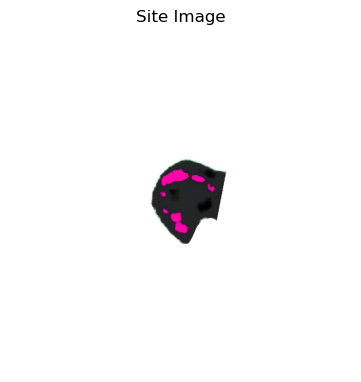

In [2]:
directory_path = os.getcwd()

mask_image = Image.open(os.path.join(directory_path, 'best_mask_1.png'))
original_image = Image.open(os.path.join(directory_path, 'best_1.png')) #predicted image

# Convert the image to RGB, which will remove the alpha channel(doing this because got transparency channel)
mask_image = mask_image.convert('RGB')
original_image = original_image.convert('RGB')


mask_array = np.array(mask_image)
original_array = np.array(original_image)

# Create mask using blue mask
def create_binary_mask(arr, target_color, threshold=30):
    lower_bound = np.array(target_color) - threshold
    upper_bound = np.array(target_color) + threshold
    mask = (arr[:, :, :3] >= lower_bound) & (arr[:, :, :3] <= upper_bound)
    return np.all(mask, axis=-1)
mask_color = [4, 255, 0]  # bright green
site_mask = create_binary_mask(mask_array, mask_color)

# Extract site from the original image that corresponds to the blue mask
site_area_array = original_array.copy()
site_area_array[~site_mask] = [255, 255, 255]  # making non-masked region white

# Convert site_area back to a PIL image and enhance its contrast
site_area_image = Image.fromarray(site_area_array)


# Display the result
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(site_area_image)
plt.title('Site Image')
plt.axis('off')
plt.show()


## Extract Buildings

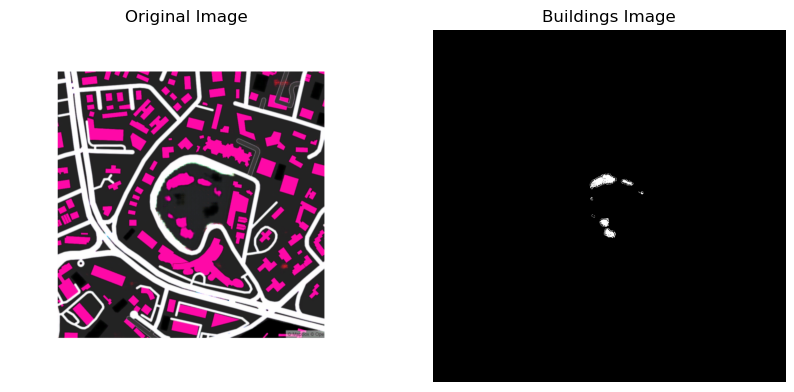

In [3]:
#detect buildings
def extract_building_regions(arr, target_color, threshold=10):
    lower_bound = np.array(target_color) - threshold
    upper_bound = np.array(target_color) + threshold
    mask = (arr[:, :, :3] >= lower_bound) & (arr[:, :, :3] <= upper_bound)
    return np.all(mask, axis=-1)
mask_color = [250, 8, 162]  # bright pink
building_mask = extract_building_regions(site_area_array, mask_color)

buildings_image = Image.fromarray(building_mask)


# Display the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(buildings_image, cmap='gray')
plt.title('Buildings Image')
plt.axis('off')
plt.show()

##  Draw contours

C:\Users\phuay\AppData\Local\Temp\ipykernel_23252\1032282974.py:36: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 2)
C:\Users\phuay\AppData\Local\Temp\ipykernel_23252\1032282974.py:40: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


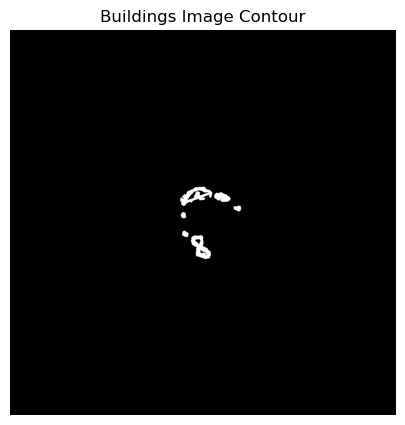

In [4]:
def approx_contours(contours, epsilon_factor=0.02):
    approximated_contours = []
    for contour in contours:
        epsilon = epsilon_factor * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        approximated_contours.append(approx)
    return approximated_contours

# convert mask to uint8 instead of bool
building_mask = building_mask.astype(np.uint8) * 255

# Apply GaussianBlur to reduce noise and improve edge detection
blurred = cv2.GaussianBlur(building_mask, (5, 5), 0)

# Use Canny edge detection
edges = cv2.Canny(blurred, 50, 150)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Approximate contours to simplify shapes
approximated_contours = approx_contours(contours)

# Draw the contours on the original image
original_approximated_contours = cv2.drawContours(building_mask.copy(), approximated_contours, -1, (255), 10)

# Draw the contours on the blank image
blank_image = np.zeros_like(building_mask)
approximated_contours_image = cv2.drawContours(blank_image, approximated_contours, -1, (255), 5)

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(buildings_image, cmap='gray')
plt.title('Buildings Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(approximated_contours_image, cmap='gray')
plt.title('Buildings Image Contour')
plt.axis('off')
plt.show()


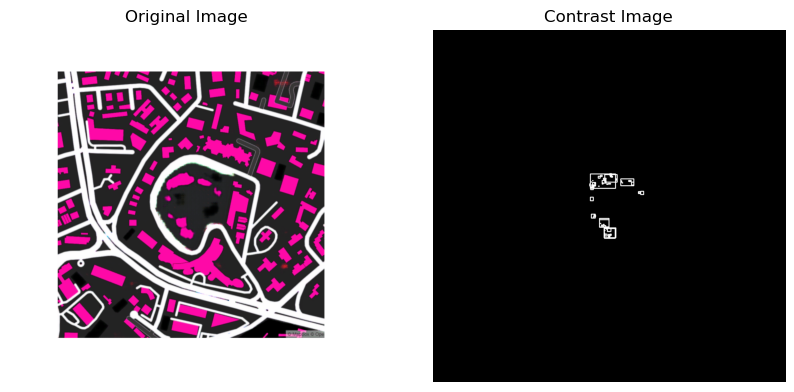

In [5]:
blank_image = np.zeros_like(building_mask)

# Iterate through each contour
for contour in approximated_contours:
    # Calculate the bounding rectangle for each contour
    x, y, w, h = cv2.boundingRect(contour)

    # Draw the rectangle on the blank image
    # (255) is the color (white), and 2 is the thickness of the rectangle lines
    cv2.rectangle(blank_image, (x, y), (x+w, y+h), (255), 2)

# Draw the contours on the blank image

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(blank_image, cmap='gray')
plt.title('Contrast Image')
plt.axis('off')
plt.show()


## Group rectangles

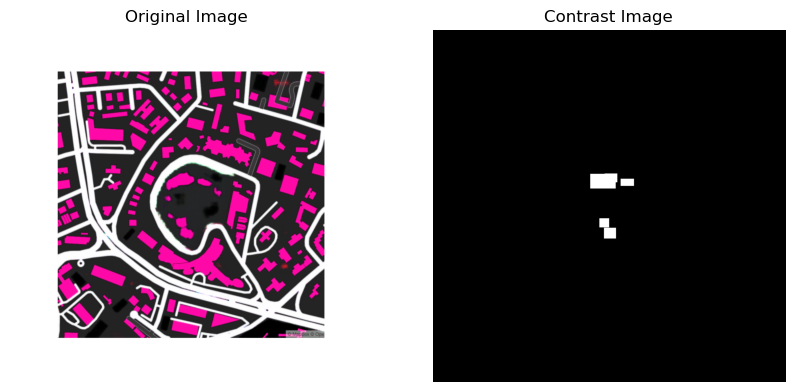

In [6]:
import numpy as np
import cv2

def remove_nested_rectangles(rectangles):
    non_nested = []
    for rect in rectangles:
        x1, y1, w1, h1 = rect
        nested = False
        for other_rect in rectangles:
            if other_rect == rect:
                continue
            x2, y2, w2, h2 = other_rect
            if x1 >= x2 and y1 >= y2 and x1 + w1 <= x2 + w2 and y1 + h1 <= y2 + h2:
                nested = True
                break
        if not nested:
            non_nested.append(rect)
    return non_nested

# Merge rectangles that are close to or overlap each other.
def merge_rectangles(rectangles, distance_threshold):
    merged = []
    while rectangles:
        a = rectangles.pop(0)
        to_merge = [a]
        i = 0
        while i < len(rectangles):
            b = rectangles[i]
            if is_close(a, b, distance_threshold):
                to_merge.append(b)
                rectangles.pop(i)
            else:
                i += 1
        xs = [x for x, _, w, _ in to_merge for x in [x, x+w]]
        ys = [y for _, y, _, h in to_merge for y in [y, y+h]]
        merged.append((min(xs), min(ys), max(xs) - min(xs), max(ys) - min(ys)))
    return merged

def is_close(rect1, rect2, threshold):
    """
    Check if two rectangles are close to each other based on a threshold.
    """
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2
    center1 = (x1 + w1 / 2, y1 + h1 / 2)
    center2 = (x2 + w2 / 2, y2 + h2 / 2)
    distance = np.hypot(center1[0] - center2[0], center1[1] - center2[1])
    return distance < threshold

blank_image = np.zeros_like(building_mask)
rectangles = [cv2.boundingRect(contour) for contour in approximated_contours]

non_nested_rectangles = remove_nested_rectangles(rectangles)
distance_threshold = 20  #threshold
merged_rectangles = merge_rectangles(non_nested_rectangles, distance_threshold)

min_width = 15
min_height = 15
# Draw the final rectangles on the blank image, but only if they are not too small
for x, y, w, h in merged_rectangles:
    if w >= min_width and h >= min_height:
        cv2.rectangle(blank_image, (x, y), (x + w, y + h), (255), -1)  # Fill the rectangle



plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(blank_image, cmap='gray')
plt.title('Contrast Image')
plt.axis('off')
plt.show()

## Find size of the generated images

In [15]:
# Count the filled pixels in blank_image (white pixels after drawing rectangles)
filled_pixels = np.sum(blank_image == 255)

# Count the pixels in site_mask (assuming site_mask is a binary mask where the site is marked with 1s or True)
mask_pixels = np.sum(site_mask)

# Find dimensions of image
image_w, image_h = original_image.size
print(image_w, image_h)

# Calculate the ratio
if mask_pixels > 0:  # To avoid division by zero
    ratio = filled_pixels / mask_pixels
else:
    ratio = 0

print(f"Ratio of filled area to site mask area: {ratio:.2f}")



1080 1080
Ratio of filled area to site mask area: 0.15
578674495
